# Grad NN Final Project

### Prelude

Here is the code for loading and cleaning up the dataset.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

'''Data = pd.read_csv("german_credit_data.csv")
Data['Saving accounts'] = Data['Saving accounts'].map({"little":0,"moderate":1,"quite rich":2 ,"rich":3 });
Data['Saving accounts'] = Data['Saving accounts'].fillna(Data['Saving accounts'].dropna().mean())

Data['Checking account'] = Data['Checking account'].map({"little":0,"moderate":1,"rich":2 });
Data['Checking account'] = Data['Checking account'].fillna(Data['Checking account'].dropna().mean())

Data['race'] = Data['race'].map({"black":0,"white":1}).astype(float)

Data['Housing'] = Data['Housing'].map({"own":0,"free":1,"rent":2}).astype(float)

Data['Purpose'] = Data['Purpose'].map({'radio/TV':0, 'education':1, 'furniture/equipment':2, 'car':3, 'business':4,
       'domestic appliances':5, 'repairs':6, 'vacation/others':7}).astype(float)

Data['Risk'] = Data['Risk'].map({"good":0,"bad":1}).astype(float)
Data = Data.drop(columns=['Unnamed: 0'])
Data.head(10)'''

import pandas as pd
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

pd.options.mode.chained_assignment = None # muting a trivial warning about PANDAS, don't worry about this
df = pd.read_csv('compas-scores-two-years.csv')
df_cleaned = df.loc[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) 
              & (df['is_recid'] != -1) & (df['c_charge_degree'] != "O") & (df['score_text'] != 'N/A')]
df_filtered = df_cleaned[['age','sex', 'race', 'juv_fel_count', 'decile_score', 'priors_count', 'is_recid', 'is_violent_recid', 
                   'v_decile_score']]
df_final = df_filtered.join(pd.get_dummies(df_filtered['race']))
df_final["sex"] = (df_final["sex"] == "Male") + 0 ## Use the binary coding for sex.

Data = df_final

Data_wb = Data[(Data['African-American'] | Data['Caucasian']) == 1]

Data = Data_wb
#print (len(Data))

Data = Data.drop(columns=['Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other', 'race', 'is_violent_recid'])

Data = Data.rename(columns={'African-American': 'race'})
Data.head(10)

,age,sex,juv_fel_count,decile_score,priors_count,is_recid,v_decile_score,race
1,34,1,0,3,0,1,1,1
2,24,1,0,4,4,1,3,1
6,41,1,0,6,14,1,2,0
8,39,0,0,1,0,0,1,0
10,27,1,0,4,0,0,4,0
11,23,1,0,6,3,1,4,1
12,37,0,0,1,0,0,1,0
13,41,1,0,4,0,0,2,1
14,47,0,0,1,1,1,1,0
15,31,1,0,3,7,1,2,1


In [50]:
q = df_final[df_final['African-American'] == 1]
print (len(q))
w = df_final[df_final['Caucasian'] == 1]
print (len(w))

print (len(Data))

3175
2103
5278


And here is the code for performing a train-test split, training a logistic regression model, and computing the test accuracy.

In [11]:
X = Data.drop(columns=["is_recid", "race"])
Y = Data['is_recid']

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=137)

tempX = Data.drop(columns=["is_recid"])
tempY = Data['is_recid']

temptrain_x, temptest_x, temptrain_y, temptest_y = train_test_split(tempX, tempY, test_size=0.2, random_state=137)


# whiteS ARE 0
# blackS ARE 1

test_x_black = test_x[temptest_x['race'] == 1]
test_y_black = test_y[temptest_x['race'] == 1]

test_x_white = test_x[temptest_x['race'] == 0]
test_y_white = test_y[temptest_x['race'] == 0]






In [63]:
q = len(temptrain_x[temptrain_x['race'] == 1])

w = len(temptrain_x[temptrain_x['race'] == 0])

race1weight = 1 - (q/(q+w))
race0weight = 1 - (w/(q+w))

print ("Weight for race label 1: ", race1weight)
print ("Weight for race label 0: ", race0weight)

e = len(temptrain_y[temptrain_y == 1])
r = len(temptrain_y[temptrain_y == 0])

risk1weight = 1 - (e/(e+r))
risk0weight = 1 - (r/(e+r))

print ("Weight for risk label 1: ", risk1weight)
print ("Weight for risk label 0: ", risk0weight)


Weight for race label 1:  0.396257697773567
Weight for race label 0:  0.603742302226433
Weight for risk label 1:  0.4971577451444813
Weight for risk label 0:  0.5028422548555187


In [12]:
# Getting low risk/high risk data

test_x_black_lowrisk = test_x_black[test_y_black == 0]
test_y_black_lowrisk = test_y_black[test_y_black == 0]

test_x_black_highrisk = test_x_black[test_y_black == 1]
test_y_black_highrisk = test_y_black[test_y_black == 1]

test_x_white_lowrisk = test_x_white[test_y_white == 0]
test_y_white_lowrisk = test_y_white[test_y_white == 0]

test_x_white_highrisk = test_x_white[test_y_white == 1]
test_y_white_highrisk = test_y_white[test_y_white == 1]

In [15]:
import torch
class Dataset(torch.utils.data.Dataset):
    
    # Create Torch Dataset object.
    def __init__(self, X, Y):

        #X = X.reshape((-1, 1, 64, 64))  
        #self.X = torch.from_numpy(X)
        #self.Y = torch.from_numpy(Y)
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        X = self.X[index]
        Y = self.Y[index]

        return {'X': X, 'Y': Y}

In [16]:
def train(epoch, net, trainDataLoader, optimizer, criterion, validDataLoader):
    net.train()
    train_loss = 0
    for sample in trainDataLoader:
        inputs, targets = sample['X'], sample['Y']
        #print (inputs, targets)
        optimizer.zero_grad()
        outputs = net.forward(inputs)
        #print ("outputs/targets", outputs, targets)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size

    net.eval()
    valid_loss = 0
    for sample in validDataLoader:
        inputs, targets = sample['X'], sample['Y']
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        valid_loss += loss.item() * batch_size

    # calculate average losses
    train_loss = train_loss/len(trainDataLoader.sampler)
    valid_loss = valid_loss/len(validDataLoader.sampler)

    if epoch % 1 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    return train_loss, valid_loss


In [17]:
import torch
from torch.autograd import Variable
import sklearn
import numpy as np

scaler = sklearn.preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
test_x_black = scaler.transform(test_x_black)
test_x_white = scaler.transform(test_x_white)
test_x_black_highrisk = scaler.transform(test_x_black_highrisk)
test_x_black_lowrisk = scaler.transform(test_x_black_lowrisk)
test_x_white_highrisk = scaler.transform(test_x_white_highrisk)
test_x_white_lowrisk = scaler.transform(test_x_white_lowrisk)

train_x = torch.from_numpy(train_x.astype(np.float32))
test_x = torch.from_numpy(test_x.astype(np.float32))
test_x_black = torch.from_numpy(test_x_black.astype(np.float32))
test_x_white = torch.from_numpy(test_x_white.astype(np.float32))
test_x_black_highrisk = torch.from_numpy(test_x_black_highrisk.astype(np.float32))
test_x_black_lowrisk = torch.from_numpy(test_x_black_lowrisk.astype(np.float32))
test_x_white_highrisk = torch.from_numpy(test_x_white_highrisk.astype(np.float32))
test_x_white_lowrisk = torch.from_numpy(test_x_white_lowrisk.astype(np.float32))



# Train_y is now a numpy object 
train_y = list(train_y)

# train_y is now a torch object 
train_y = torch.as_tensor(train_y, dtype = torch.float32)
test_y = torch.as_tensor(list(test_y), dtype=torch.float32)
test_y_black = torch.as_tensor(list(test_y_black), dtype=torch.float32)
test_y_white = torch.as_tensor(list(test_y_white), dtype=torch.float32)
test_y_black_highrisk = torch.as_tensor(list(test_y_black_highrisk), dtype=torch.float32)
test_y_black_lowrisk = torch.as_tensor(list(test_y_black_lowrisk), dtype=torch.float32)
test_y_white_highrisk = torch.as_tensor(list(test_y_white_highrisk), dtype=torch.float32)
test_y_white_lowrisk = torch.as_tensor(list(test_y_white_lowrisk), dtype=torch.float32)


train_y = train_y.view(train_y.shape[0],1)
test_y = test_y.view(test_y.shape[0],1)
test_y_black = test_y_black.view(test_y_black.shape[0],1)
test_y_white = test_y_white.view(test_y_white.shape[0],1)
test_y_black_highrisk = test_y_black_highrisk.view(test_y_black_highrisk.shape[0],1)
test_y_black_lowrisk = test_y_black_lowrisk.view(test_y_black_lowrisk.shape[0],1)
test_y_white_highrisk = test_y_white_highrisk.view(test_y_white_highrisk.shape[0],1)
test_y_white_lowrisk = test_y_white_lowrisk.view(test_y_white_lowrisk.shape[0],1)

n_samples,n_features=train_x.shape

In [18]:
def accuracy(model, test_x):
    model.eval()
    with torch.no_grad():
     y_pred=model(test_x)
     y_pred_class=y_pred.round()
     accuracy=(y_pred_class.eq(test_y).sum())/float(test_y.shape[0])
     print(accuracy.item())

In [84]:
# YOUR CODE HERE

import torch
from torch.autograd import Variable


class DNN_model(torch.nn.Module):
 def __init__(self,no_input_features):
    super(DNN_model,self).__init__()
    self.layer1 = torch.nn.Linear(no_input_features,20)
    self.layer2 = torch.nn.Linear(20,20)
    self.layer5 = torch.nn.Linear(20,1)
    
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
        
    self.seq = torch.nn.Sequential(
        self.layer1,
        self.relu,
        self.layer2,
        self.relu
    )

 def forward(self,x):
    # YOUR ANSWER HERE
    return self.sigmoid(self.layer5(self.seq(x)))

print(train_x.shape)
print (type(train_x))

batch_size = 10
trainSignData = Dataset(train_x, train_y)
print (len(trainSignData))
trainDataLoader = torch.utils.data.DataLoader(trainSignData, shuffle=True, batch_size=batch_size)
testSignData = Dataset(test_x, test_y)
testDataLoader = torch.utils.data.DataLoader(testSignData, shuffle=True, batch_size=batch_size)

dnnmodel = DNN_model(train_x.shape[1])
dnnepochs = 15
dnnlr = 1e-4
criterion = torch.nn.BCELoss()
dnnoptimizer = torch.optim.Adam(dnnmodel.parameters(), lr=dnnlr, weight_decay=1e-5)
for epoch in range(dnnepochs):
    #print ("hey")
    print ("epoch", epoch)
    train(epoch, dnnmodel, trainDataLoader, dnnoptimizer, criterion, testDataLoader)

torch.save(dnnmodel, "dnnmodel.pt")

torch.Size([4222, 6])
<class 'torch.Tensor'>
4222
epoch 0
Epoch: 0 	Training Loss: 0.692241 	Validation Loss: 0.687840
epoch 1
Epoch: 1 	Training Loss: 0.677958 	Validation Loss: 0.671380
epoch 2
Epoch: 2 	Training Loss: 0.656889 	Validation Loss: 0.648734
epoch 3
Epoch: 3 	Training Loss: 0.632923 	Validation Loss: 0.630003
epoch 4
Epoch: 4 	Training Loss: 0.616985 	Validation Loss: 0.619643
epoch 5
Epoch: 5 	Training Loss: 0.608992 	Validation Loss: 0.615971
epoch 6
Epoch: 6 	Training Loss: 0.605588 	Validation Loss: 0.612647
epoch 7
Epoch: 7 	Training Loss: 0.602102 	Validation Loss: 0.611679
epoch 8
Epoch: 8 	Training Loss: 0.601338 	Validation Loss: 0.609744
epoch 9
Epoch: 9 	Training Loss: 0.599919 	Validation Loss: 0.608894
epoch 10
Epoch: 10 	Training Loss: 0.599399 	Validation Loss: 0.608251
epoch 11
Epoch: 11 	Training Loss: 0.599326 	Validation Loss: 0.608146
epoch 12
Epoch: 12 	Training Loss: 0.597559 	Validation Loss: 0.606075
epoch 13
Epoch: 13 	Training Loss: 0.596635 	Va

In [85]:
#print (dnnmodel.forward(test_x).round())

accuracy(dnnmodel, test_x)

0.6865530014038086


#### Q4: Show the ROC curves for the black and white subgroups, and plot the points corresponding to the different strategies clearly identified. The resulting curve should look like the ROC curve in the FICO score case study that was discussed in class.  (5 points)

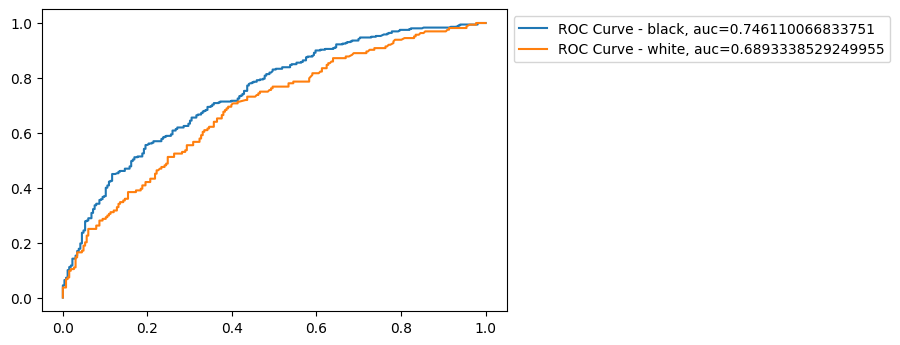

In [28]:
import matplotlib.pyplot as plt
from sklearn import metrics

from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

blackPreds = dnnmodel(test_x_black).detach()
whitePreds = dnnmodel(test_x_white).detach()

fpr_m, tpr_m, thresholds_m = metrics.roc_curve(test_y_black, blackPreds)
auc = metrics.roc_auc_score(test_y_black, blackPreds)
plt.plot(fpr_m,tpr_m,label="ROC Curve - black, auc="+str(auc))

fpr_f, tpr_f, thresholds_f = metrics.roc_curve(test_y_white, whitePreds)
auc = metrics.roc_auc_score(test_y_white, whitePreds)
plt.plot(fpr_f,tpr_f,label="ROC Curve - white, auc="+str(auc))

# lr_prediction_black_threshold = lr_prediction_black.applymap(lambda x: 1 if x > minBlackThreshold else 0)
# lr_prediction_white_threshold = lr_prediction_white.applymap(lambda x: 1 if x > minWhiteThreshold else 0)


# ax.scatter(bfp/(bfp + btn), btp/(btp + bfn), c='black', marker='^', s=100, label='Max Profit Black')
# ax.scatter(wfp/(wfp + wtn), wtp/(wtp + wfn), c='green', marker='^', s= 100, label="Max Profit White")

plt.legend(loc=0, bbox_to_anchor=(1,1))

#### Q5: (i) Do a calibration plot that plots the fraction of defendants recidividating within two years as a function of the predicted probability of recidivism, for black defendants and white defendants. (ii) Comment (in a couple of sentences) if you believe that the score satisfies sufficiency across racial groups.      (5 points)

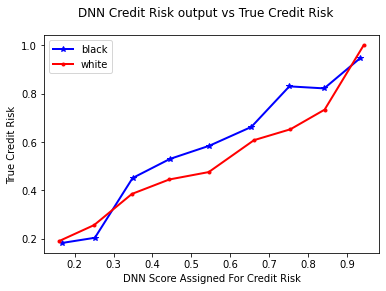

In [29]:
# YOUR CODE HERE 
from sklearn.calibration import calibration_curve
y_m, x_m = calibration_curve(
    test_y_black, 
    blackPreds, 
    n_bins=10)

y_f, x_f = calibration_curve(
    test_y_white, 
    whitePreds, 
    n_bins=10)


fig, ax = plt.subplots()

plt.plot(x_m, y_m, color='blue', 
         marker='*', 
         linewidth = 2, 
         label='black')

plt.plot(x_f, y_f, color='red', 
         marker='.', 
         linewidth = 2, 
         label='white')

# # reference line, legends, and axis labels
ax.set_xlabel('DNN Score Assigned For Credit Risk')
ax.set_ylabel('True Credit Risk')
fig.suptitle('DNN Credit Risk output vs True Credit Risk')
plt.legend()
plt.show()



Being sufficient means $Y \perp A \mid R$.  Sufficiency doesn't hold here, as whites are getting predicted to have higher credit risk even when their true credit risk isn't as high (the lines don't match up).  So, whites are getting discriminated against.

#### Q6: (i) Plot the distributions of scores received by the positive class (recidivists) and the distribution of scores received by the negative class (non-recidivists) for black and white defendants. (ii) Based on these plots, comment (in a couple of sentences) if this score satisfies separation.  (5 points)

/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_72239/695349462.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(whiteLowRiskPreds,
/var/folders/3k/nhgpsd_x0y5111nl043x8tgh0000gn/T/ipykernel_72239/695349462.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(blackLowRiskPreds,
/v

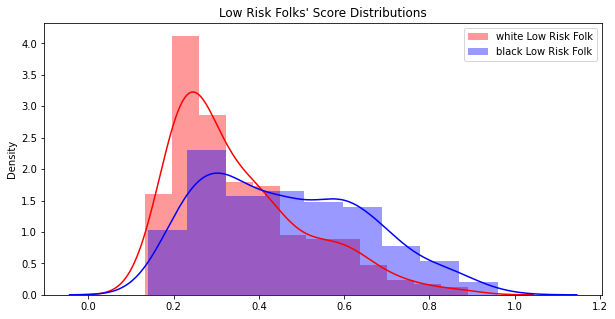

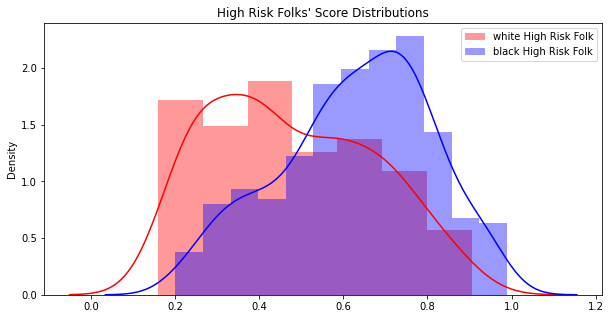

In [86]:
# YOUR CODE HERE

#print (test_y_white.head())

blackLowRiskPreds = dnnmodel(test_x_black_lowrisk).detach()
blackHighRiskPreds = dnnmodel(test_x_black_highrisk).detach()

whiteLowRiskPreds = dnnmodel(test_x_white_lowrisk).detach()
whiteHighRiskPreds = dnnmodel(test_x_white_highrisk).detach()

import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(whiteLowRiskPreds, 
             color="red", 
             label="white Low Risk Folk").set(title = "Low Risk Folks' Score Distributions")
sns.distplot(blackLowRiskPreds, 
             color="blue", 
             label="black Low Risk Folk").set(title = "Low Risk Folks' Score Distributions")
plt.legend()

plt.figure(figsize=(10,5))
sns.distplot(whiteHighRiskPreds, 
             color="red", 
             label="white High Risk Folk").set(title = "High Risk Folks' Score Distributions")
sns.distplot(blackHighRiskPreds, 
             color="blue", 
             label="black High Risk Folk").set(title = "High Risk Folks' Score Distributions")
plt.legend()




Separation means that $R \perp A \mid Y$.  So given the true label of recidivism, the logistic regression output must be independent of the race sensitive variable $A$.  This does NOT satisfy separation, because for both labels (non-recidivists and recidivists), we can see that the model outputted significantly lower scores for white people.

In [87]:
def falseaLossTrueLossSeparationHelper(model, data, labels, verbose=True):
    data = pd.DataFrame(data.numpy())
    labels = pd.DataFrame(labels.numpy())
    raceIndex = 2
    xd = data[raceIndex] < 0
    dx = (labels == 1).squeeze()

    whiteTrueData = data[(data[raceIndex] < 0) & (labels == 1).squeeze()]
    whiteFalseData = data[(data[raceIndex] < 0) & (labels == 0).squeeze()]

    blackTrueData = data[(data[raceIndex] > 0) & (labels == 1).squeeze()]
    blackFalseData = data[(data[raceIndex] > 0) & (labels == 0).squeeze()]
    
    whiteTrueData = torch.tensor(whiteTrueData.values)
    whiteFalseData = torch.tensor(whiteFalseData.values)
    
    blackTrueData = torch.tensor(blackTrueData.values)
    blackFalseData = torch.tensor(blackFalseData.values)
    
    whiteTruePreds = model(whiteTrueData)
    whiteFalsePreds = model(whiteFalseData)
    
    blackTruePreds = model(blackTrueData)
    blackFalsePreds = model(blackFalseData)
    
    whiteTruePosProb = (torch.sum(whiteTruePreds.round())/len(whiteTrueData))
    whiteFalsePosProb = (torch.sum(whiteFalsePreds.round())/len(whiteFalseData))
    
    blackTruePosProb = (torch.sum(blackTruePreds.round())/len(blackTrueData))
    blackFalsePosProb = (torch.sum(blackFalsePreds.round())/len(blackFalseData))
    
    print ("whiteTruePosProb(prob of marking a high risk white): ", whiteTruePosProb.detach())
    print ("blackTruePosProb(prob of marking a high risk black): ", blackTruePosProb.detach())

    print ("whiteFalsePosProb(prob of marking a low risk white): ", whiteFalsePosProb.detach())    
    print ("blackFalsePosProb(prob of marking a low risk black): ", blackFalsePosProb.detach())
    
    falseLoss = abs(whiteFalsePosProb - blackFalsePosProb)
    trueLoss = abs(whiteTruePosProb - blackTruePosProb)
    
    # R = model output
    # A = race (0 = white), (1 = black)
    # Y = 0 (low risk), Y = 1 (high risk)
    
    if verbose:
        print ("|P(R = 1 | A = 1, Y = 0) - P(R = 1 | A = 0, Y = 0)| = ", falseLoss.item())
        print ("|P(R = 1 | A = 1, Y = 1) - P(R = 1 | A = 0, Y = 1)| = ", trueLoss.item())
    return falseLoss, trueLoss
    
def maxSeparation(model, data, labels):
    res = falseaLossTrueLossSeparationHelper(model, data, labels)
    return max(res[0].item(), res[1].item())
    
def separation(model, data, labels):
    maxSep = maxSeparation(model, data, labels)
    eps = 0.05
    return (maxSep < eps)

def separationLoss(model, data, labels):
    falseLoss, trueLoss = falseaLossTrueLossSeparationHelper(model, data, labels, verbose=False)
    return falseLoss + trueLoss

print ("Does the model satisfy separation: ", separation(dnnmodel, test_x, test_y))

whiteTruePosProb(prob of marking a high risk white):  tensor(0.6436)
blackTruePosProb(prob of marking a high risk black):  tensor(1.)
whiteFalsePosProb(prob of marking a low risk white):  tensor(0.2830)
blackFalsePosProb(prob of marking a low risk black):  tensor(0.8889)
|P(R = 1 | A = 1, Y = 0) - P(R = 1 | A = 0, Y = 0)| =  0.6059061288833618
|P(R = 1 | A = 1, Y = 1) - P(R = 1 | A = 0, Y = 1)| =  0.35641545057296753
Does the model satisfy separation:  False


In [89]:
# creating new dataset

raceX = Data.drop(columns=['is_recid', 'race'])
raceY = Data['race']

racetrain_x, racetest_x, racetrain_y, racetest_y = train_test_split(raceX, raceY, test_size=0.2, random_state=137)

scaler = sklearn.preprocessing.StandardScaler()
racetrain_x = scaler.fit_transform(racetrain_x)
racetest_x = scaler.transform(racetest_x)

racetrain_x = torch.from_numpy(racetrain_x.astype(np.float32))
racetest_x = torch.from_numpy(racetest_x.astype(np.float32))

# Train_y is now a numpy object 
racetrain_y = list(racetrain_y)

# train_y is now a torch object 
racetrain_y = torch.as_tensor(racetrain_y, dtype = torch.float32)
racetest_y = torch.as_tensor(list(racetest_y), dtype=torch.float32)

racetrain_y = racetrain_y.view(racetrain_y.shape[0],1)
racetest_y = racetest_y.view(racetest_y.shape[0],1)

n_samples,n_features=racetrain_x.shape


In [90]:
from copy import deepcopy

batch_size = 10
raceTrainData = Dataset(racetrain_x, racetrain_y)
raceTrainDataLoader = torch.utils.data.DataLoader(raceTrainData, shuffle=True, batch_size=batch_size)
raceTestData = Dataset(racetest_x, racetest_y)
raceTestDataLoader = torch.utils.data.DataLoader(raceTestData, shuffle=True, batch_size=batch_size)


'''for child in dnnmodel.seq.children():
    for param in child.parameters():
        print (param)'''

savedModel = deepcopy(dnnmodel)

class RaceDNNModel(torch.nn.Module):
    def __init__(self, savedModel):
        super(RaceDNNModel,self).__init__()
        self.seq = savedModel.seq
        
        self.racelayer1 = torch.nn.Linear(20,20)
        self.racelayer2 = torch.nn.Linear(20,20)
        self.racelayer3 = torch.nn.Linear(20,1)
            
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
        self.raceseq = torch.nn.Sequential(
            self.racelayer1,
            self.relu,
            self.racelayer2,
            self.relu,
            self.racelayer3,
            self.sigmoid
        )
        
        
        for child in self.seq.children():
            for param in child.parameters():
                #print (param)
                param.requires_grad = False

        self.seq.eval()
    
    def forward(self, x):
        return self.raceseq(self.seq(x))
        
racednnmodel = RaceDNNModel(savedModel)

racednnepochs = 15
racednnlr = 1e-4
def BCELoss_class_weighted(weights):
    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)
    return loss


criterion = BCELoss_class_weighted(weights = [2*race0weight, 2*race1weight])
racednnoptimizer = torch.optim.Adam([param for param in racednnmodel.parameters() if param.requires_grad == True], lr=racednnlr, weight_decay = 1e-5)
for epoch in range(racednnepochs):
    #print ("hey")
    print ("epoch", epoch)
    train(epoch, racednnmodel, raceTrainDataLoader, racednnoptimizer, criterion, raceTestDataLoader)

accuracy(racednnmodel, racetest_x)
torch.save(racednnmodel, "racednnmodel.pt")

        
    






epoch 0
Epoch: 0 	Training Loss: 0.662172 	Validation Loss: 0.657780
epoch 1
Epoch: 1 	Training Loss: 0.647130 	Validation Loss: 0.635640
epoch 2
Epoch: 2 	Training Loss: 0.629793 	Validation Loss: 0.615608
epoch 3
Epoch: 3 	Training Loss: 0.619816 	Validation Loss: 0.605378
epoch 4
Epoch: 4 	Training Loss: 0.614365 	Validation Loss: 0.600376
epoch 5
Epoch: 5 	Training Loss: 0.613744 	Validation Loss: 0.598186
epoch 6
Epoch: 6 	Training Loss: 0.613429 	Validation Loss: 0.597366
epoch 7
Epoch: 7 	Training Loss: 0.612428 	Validation Loss: 0.596677
epoch 8
Epoch: 8 	Training Loss: 0.611047 	Validation Loss: 0.596244
epoch 9
Epoch: 9 	Training Loss: 0.610666 	Validation Loss: 0.595857
epoch 10
Epoch: 10 	Training Loss: 0.610894 	Validation Loss: 0.596420
epoch 11
Epoch: 11 	Training Loss: 0.610435 	Validation Loss: 0.596298
epoch 12
Epoch: 12 	Training Loss: 0.610300 	Validation Loss: 0.596019
epoch 13
Epoch: 13 	Training Loss: 0.610660 	Validation Loss: 0.596547
epoch 14
Epoch: 14 	Traini

In [75]:
torch.set_printoptions(profile="full")
#print(racednnmodel.forward(test_x).detach().round())

#print (test_y)